In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from pycox.models import MTLR

from pycox.evaluation import EvalSurv
from pycox.simulations import SimStudyLinearPH

import torch
import torchtuples as tt

# Read data

In [2]:
df_train = pd.read_csv('train.csv')
df_train = pd.DataFrame(df_train)

df_test = pd.read_csv('test.csv')
df_test = pd.DataFrame(df_test)

In [3]:
df_train.head()

,Sex,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage,duration,event
0,Male,41,65,Ileocecal Junction,II,29,1,T3,N1a,M0,IIIB,110,0
1,Male,54,95,Ascending Colon,II,37,0,T4a,N0,M0,IIB,107,0
2,Female,78,65,Sigmoid Colon,II,20,2,T4b,N1b,M0,IIIC,106,0
3,Female,33,150,"Large Intestine, NOS",II,9,0,T4a,N0,M0,IIB,105,0
4,Male,58,100,Descending Colon,III,6,1,T4a,N1a,M0,IIIB,102,0


In [4]:
# to label encoding categorical variables
le = LabelEncoder() #label encoder
cat_list = ['Sex','Site', 'Grade', 'T', 'N', 'M', 'Stage'] #list of categorical variables
for cat in cat_list:
    df_train[cat] = le.fit_transform(df_train[cat])
    df_test[cat] = le.fit_transform(df_test[cat])

df_train.head()

,Sex,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage,duration,event
0,1,41,65,3,1,29,1,2,2,0,7,110,0
1,1,54,95,0,1,37,0,4,0,0,3,107,0
2,0,78,65,7,1,20,2,5,3,0,8,106,0
3,0,33,150,4,1,9,0,4,0,0,3,105,0
4,1,58,100,1,2,6,1,4,2,0,7,102,0


In [5]:
# function to get targets variable
get_target = lambda df: (df['duration'].values, df['event'].values)

# to standardize and get dependent variables 
cols_standardize = ['Age', 'Size', 'Lymph.nodes.examined', 'Lymph.nodes.positive'] # list of variables for standardization
cols_leave = ['Sex','Site', 'Grade', 'T', 'N', 'M', 'Stage'] #categorical variables 

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

num_durations = 10

labtrans = MTLR.label_transform(num_durations)

y_train = labtrans.fit_transform(*get_target(df_train))
y_test = labtrans.transform(*get_target(df_test))

train = (x_train, y_train)
val = (x_test, y_test)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

# Neural Network

In [54]:
in_features = x_train.shape[1]
num_nodes = [64,8]
# out_features = 1
out_features = labtrans.out_features
batch_norm = True
dropout = 0.4
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model_cox = MTLR(net, tt.optim.Adam(lr=0.01,amsgrad=True), duration_index=labtrans.cuts) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks,val_data =val)


0:	[0s / 0s],		train_loss: 1.9718,	val_loss: 1.5023
1:	[0s / 0s],		train_loss: 1.7053,	val_loss: 1.4044
2:	[0s / 0s],		train_loss: 1.5670,	val_loss: 1.3791
3:	[0s / 0s],		train_loss: 1.5434,	val_loss: 1.3521
4:	[0s / 0s],		train_loss: 1.5636,	val_loss: 1.3239
5:	[0s / 0s],		train_loss: 1.5199,	val_loss: 1.3111
6:	[0s / 0s],		train_loss: 1.4615,	val_loss: 1.3017
7:	[0s / 0s],		train_loss: 1.4255,	val_loss: 1.2883
8:	[0s / 0s],		train_loss: 1.4225,	val_loss: 1.2860
9:	[0s / 0s],		train_loss: 1.4262,	val_loss: 1.2911
10:	[0s / 0s],		train_loss: 1.3894,	val_loss: 1.2851
11:	[0s / 0s],		train_loss: 1.4288,	val_loss: 1.2923
12:	[0s / 0s],		train_loss: 1.4198,	val_loss: 1.3092
13:	[0s / 0s],		train_loss: 1.4331,	val_loss: 1.3301
14:	[0s / 0s],		train_loss: 1.4279,	val_loss: 1.3549
15:	[0s / 0s],		train_loss: 1.4186,	val_loss: 1.3521
16:	[0s / 0s],		train_loss: 1.4328,	val_loss: 1.3603
17:	[0s / 0s],		train_loss: 1.3696,	val_loss: 1.3315
18:	[0s / 0s],		train_loss: 1.3969,	val_loss: 1.3112
19:

0.7298553719008265

<Figure size 864x864 with 0 Axes>

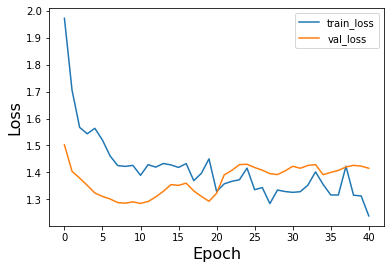

In [55]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
#model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.interpolate(10).predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, durations_test, events_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td('antolini') 
cox_index  # cox_index  at all

0.17115440380258484

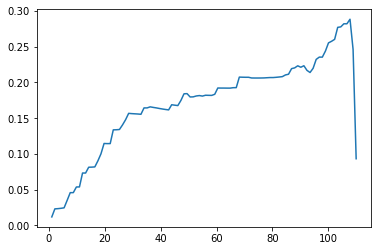

In [56]:
# integrated_brier_score at all
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

# Internal validation

In [57]:
# c-index at  all
durations_test0, events_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0,durations_test0, events_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td('antolini') 
cox_index0 

0.5178904574945006

0.3694534115921843

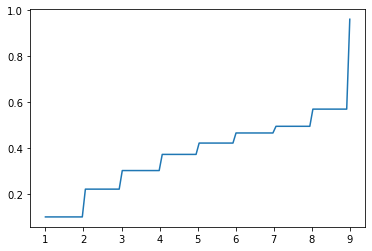

In [58]:
# brier score at all
time_grid0 = np.linspace(durations_test0.min(), durations_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [61]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.5270613986285133
The C-index Low 95% CI:0.5243342017956544
The C-index High 95% CI:0.5297885954613722


In [62]:
# External
ex_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.6429554797985696
The C-index Low 95% CI:0.6400155618109932
The C-index High 95% CI:0.645895397786146


# Save

In [59]:
model_cox.save_model_weights('myweights_NMTLR.pt')

# LASSO var

In [63]:
df_train_lasso = df_train[["Age","Size","Site","Grade","Lymph.nodes.examined","Lymph.nodes.positive","T","N","M","Stage"]]
df_test_lasso = df_test[["Age","Size","Site","Grade","Lymph.nodes.examined","Lymph.nodes.positive","T","N","M","Stage"]]
df_train_lasso.head()

,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage
0,41,65,3,1,29,1,2,2,0,7
1,54,95,0,1,37,0,4,0,0,3
2,78,65,7,1,20,2,5,3,0,8
3,33,150,4,1,9,0,4,0,0,3
4,58,100,1,2,6,1,4,2,0,7


In [64]:
# to standardize and get dependent variables 
cols_standardize = ['Age', 'Size', 'Lymph.nodes.examined', 'Lymph.nodes.positive'] # list of variables for standardization
cols_leave = ['Site', 'Grade', 'T', 'N', 'M', 'Stage'] #categorical variables 

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train_lasso).astype('float32')
x_test = x_mapper.transform(df_test_lasso).astype('float32')

train = (x_train, y_train)
val = (x_test, y_test)

In [95]:
in_features = x_train.shape[1]
num_nodes = [64,16]
# out_features = 1
out_features = labtrans.out_features
batch_norm = True
dropout = 0.4
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model_cox = MTLR(net, tt.optim.Adam(lr=0.01,amsgrad=True), duration_index=labtrans.cuts) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks,val_data =val)


0:	[0s / 0s],		train_loss: 1.8796,	val_loss: 1.4309
1:	[0s / 0s],		train_loss: 1.5989,	val_loss: 1.3784
2:	[0s / 0s],		train_loss: 1.5701,	val_loss: 1.3349
3:	[0s / 0s],		train_loss: 1.5166,	val_loss: 1.3308
4:	[0s / 0s],		train_loss: 1.4018,	val_loss: 1.3485
5:	[0s / 0s],		train_loss: 1.4565,	val_loss: 1.3482
6:	[0s / 0s],		train_loss: 1.5043,	val_loss: 1.3129
7:	[0s / 0s],		train_loss: 1.3950,	val_loss: 1.3026
8:	[0s / 0s],		train_loss: 1.3718,	val_loss: 1.2922
9:	[0s / 0s],		train_loss: 1.3735,	val_loss: 1.2971
10:	[0s / 0s],		train_loss: 1.4272,	val_loss: 1.2812
11:	[0s / 0s],		train_loss: 1.4033,	val_loss: 1.2727
12:	[0s / 0s],		train_loss: 1.4113,	val_loss: 1.2649
13:	[0s / 0s],		train_loss: 1.3549,	val_loss: 1.2883
14:	[0s / 0s],		train_loss: 1.3180,	val_loss: 1.2892
15:	[0s / 0s],		train_loss: 1.3461,	val_loss: 1.2675
16:	[0s / 0s],		train_loss: 1.3794,	val_loss: 1.2577
17:	[0s / 0s],		train_loss: 1.3298,	val_loss: 1.2576
18:	[0s / 0s],		train_loss: 1.4319,	val_loss: 1.2699
19:

0.6947314049586777

<Figure size 864x864 with 0 Axes>

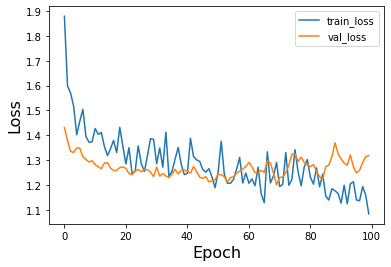

In [97]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
#model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.interpolate(10).predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, durations_test, events_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td('antolini') 
cox_index  # cox_index  at all

0.15986563006039786

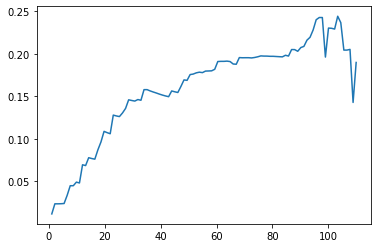

In [98]:
# integrated_brier_score at all
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

In [99]:
# c-index at  all
durations_test0, events_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0,durations_test0, events_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td('antolini') 
cox_index0 

0.516414668782892

0.3818974371266225

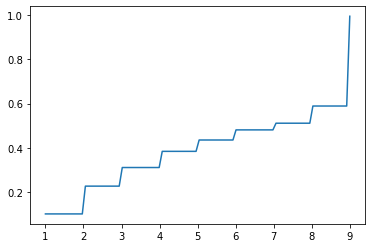

In [100]:
# brier score at all
time_grid0 = np.linspace(durations_test0.min(), durations_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [101]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.5229286780906425
The C-index Low 95% CI:0.5204150867378446
The C-index High 95% CI:0.5254422694434403


In [102]:
# External
ex_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.6069733730906853
The C-index Low 95% CI:0.6041472884052311
The C-index High 95% CI:0.6097994577761395


# TNM

In [103]:
df_train_tnm = df_train[["T","N","M","Stage"]]
df_test_tnm = df_test[["T","N","M","Stage"]]
df_train_tnm.head()

,T,N,M,Stage
0,2,2,0,7
1,4,0,0,3
2,5,3,0,8
3,4,0,0,3
4,4,2,0,7


In [104]:
# to standardize and get dependent variables 
cols_leave = ['T', 'N', 'M', 'Stage'] #categorical variables 
leave = [(col, None) for col in cols_leave]
x_mapper = DataFrameMapper(leave)

x_train = x_mapper.fit_transform(df_train_tnm).astype('float32')
x_test = x_mapper.transform(df_test_tnm).astype('float32')

train = (x_train, y_train)
val = (x_test, y_test)

In [153]:
in_features = x_train.shape[1]
num_nodes = [128,64,64]
# out_features = 1
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model_cox = MTLR(net, tt.optim.Adam(lr=0.01,amsgrad=True), duration_index=labtrans.cuts) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks,val_data =val)


0:	[0s / 0s],		train_loss: 1.7085,	val_loss: 1.6233
1:	[0s / 0s],		train_loss: 1.5306,	val_loss: 1.3622
2:	[0s / 0s],		train_loss: 1.6870,	val_loss: 1.4017
3:	[0s / 0s],		train_loss: 1.6610,	val_loss: 1.3791
4:	[0s / 0s],		train_loss: 1.5498,	val_loss: 1.2808
5:	[0s / 0s],		train_loss: 1.3879,	val_loss: 1.2652
6:	[0s / 0s],		train_loss: 1.4268,	val_loss: 1.2588
7:	[0s / 0s],		train_loss: 1.4387,	val_loss: 1.2640
8:	[0s / 0s],		train_loss: 1.3672,	val_loss: 1.2684
9:	[0s / 0s],		train_loss: 1.3902,	val_loss: 1.3328
10:	[0s / 0s],		train_loss: 1.5891,	val_loss: 1.3113
11:	[0s / 0s],		train_loss: 1.3718,	val_loss: 1.2905
12:	[0s / 0s],		train_loss: 1.4044,	val_loss: 1.3360
13:	[0s / 0s],		train_loss: 1.3733,	val_loss: 1.2748
14:	[0s / 0s],		train_loss: 1.3088,	val_loss: 1.2548
15:	[0s / 0s],		train_loss: 1.2849,	val_loss: 1.2680
16:	[0s / 0s],		train_loss: 1.3173,	val_loss: 1.2695
17:	[0s / 0s],		train_loss: 1.3199,	val_loss: 1.2487
18:	[0s / 0s],		train_loss: 1.3173,	val_loss: 1.2864
19:

0.6012396694214877

<Figure size 864x864 with 0 Axes>

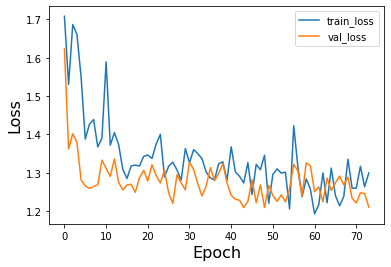

In [154]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
#model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.interpolate(10).predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, durations_test, events_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td('antolini') 
cox_index  # cox_index  at all

0.1831740562879016

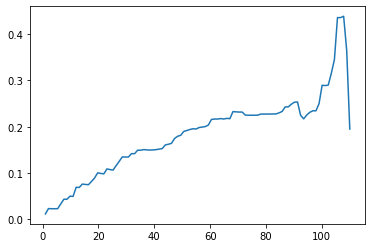

In [155]:
# integrated_brier_score at all
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

In [156]:
# c-index at  all
durations_test0, events_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0,durations_test0, events_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td('antolini') 
cox_index0 

0.49750786623228355

0.38350888378536285

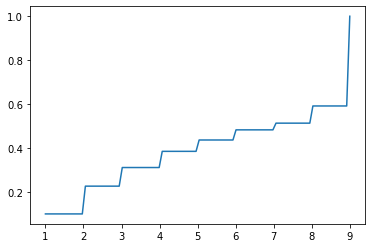

In [157]:
# brier score at all
time_grid0 = np.linspace(durations_test0.min(), durations_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [158]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.5430369012938394
The C-index Low 95% CI:0.540300198842291
The C-index High 95% CI:0.5457736037453879


In [159]:
# External
ex_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.5550713979898789
The C-index Low 95% CI:0.5521492051256768
The C-index High 95% CI:0.5579935908540811
